# COVID-19 pandemic data analysis

### Obtain data from John Hopkins CSSE repository 

Using @GaelVaroquaux [`covid-dashboard`](https://github.com/covid19-dash/covid-dashboard) helpers

In [1]:
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, "./covid-dashboard/")

In [2]:
import data_input

data = data_input.get_data()

In [3]:
data

type             confirmed                                              \
iso                    AFG    AGO     ALB     AND                  ARE   
country_region Afghanistan Angola Albania Andorra United Arab Emirates   
date                                                                     
2020-01-22               0      0       0       0                    0   
2020-01-23               0      0       0       0                    0   
2020-01-24               0      0       0       0                    0   
2020-01-25               0      0       0       0                    0   
2020-01-26               0      0       0       0                    0   
...                    ...    ...     ...     ...                  ...   
2020-05-15            6053     48     916     761                21831   
2020-05-16            6402     48     933     761                22627   
2020-05-17            6664     48     946     761                23358   
2020-05-18            7072     50     948     761                24190   
2020-05-19            7653     52     949     761                25063   

type                                                                    ...  \
iso                  ARG     ARM                 ATG       AUS     AUT  ...   
country_region Argentina Armenia Antigua and Barbuda Australia Austria  ...   
date                                                                    ...   
2020-01-22             0       0                   0         0       0  ...   
2020-01-23             0       0                   0         0       0  ...   
2020-01-24             0       0                   0         0       0  ...   
2020-01-25             0       0                   0         0       0  ...   
2020-01-26             0       0                   0         4       0  ...   
...                  ...     ...                 ...       ...     ...  ...   
2020-05-15          7479    4044                  25      7035   16109  ...   
2020-05-16          7805    4283                  25      7044   16201  ...   
2020-05-17          8068    4472                  25      7054   16242  ...   
2020-05-18          8371    4823                  25      7068   16269  ...   
2020-05-19          8809    5041                  25      7072   16321  ...   

type             death                           \
iso                URY           USA        UZB   
country_region Uruguay United States Uzbekistan   
date                                              
2020-01-22           0             0          0   
2020-01-23           0             0          0   
2020-01-24           0             0          0   
2020-01-25           0             0          0   
2020-01-26           0             0          0   
...                ...           ...        ...   
2020-05-15          19         87530         11   
2020-05-16          19         88754         11   
2020-05-17          20         89562         12   
2020-05-18          20         90347         13   
2020-05-19          20         91921         13   

type                                                                     \
iso                                         VCT       VEN     VNM   YEM   
country_region Saint Vincent and the Grenadines Venezuela Vietnam Yemen   
date                                                                      
2020-01-22                                    0         0       0     0   
2020-01-23                                    0         0       0     0   
2020-01-24                                    0         0       0     0   
2020-01-25                                    0         0       0     0   
2020-01-26                                    0         0       0     0   
...                                         ...       ...     ...   ...   
2020-05-15                                    0        10       0    15   
2020-05-16                                    0        10       0    18   
2020-05-17                           

### Select countries of interest and retrieve confirmed cases and deaths dataframes

In [4]:
COUNTRIES = ["ESP", "GBR", "DEU", "AUT"]

In [5]:
confirmed = data["confirmed"][COUNTRIES]
dead = data["death"][COUNTRIES]

Text(0.5, 1.0, 'Log-scale plot of number of confirmed cases')

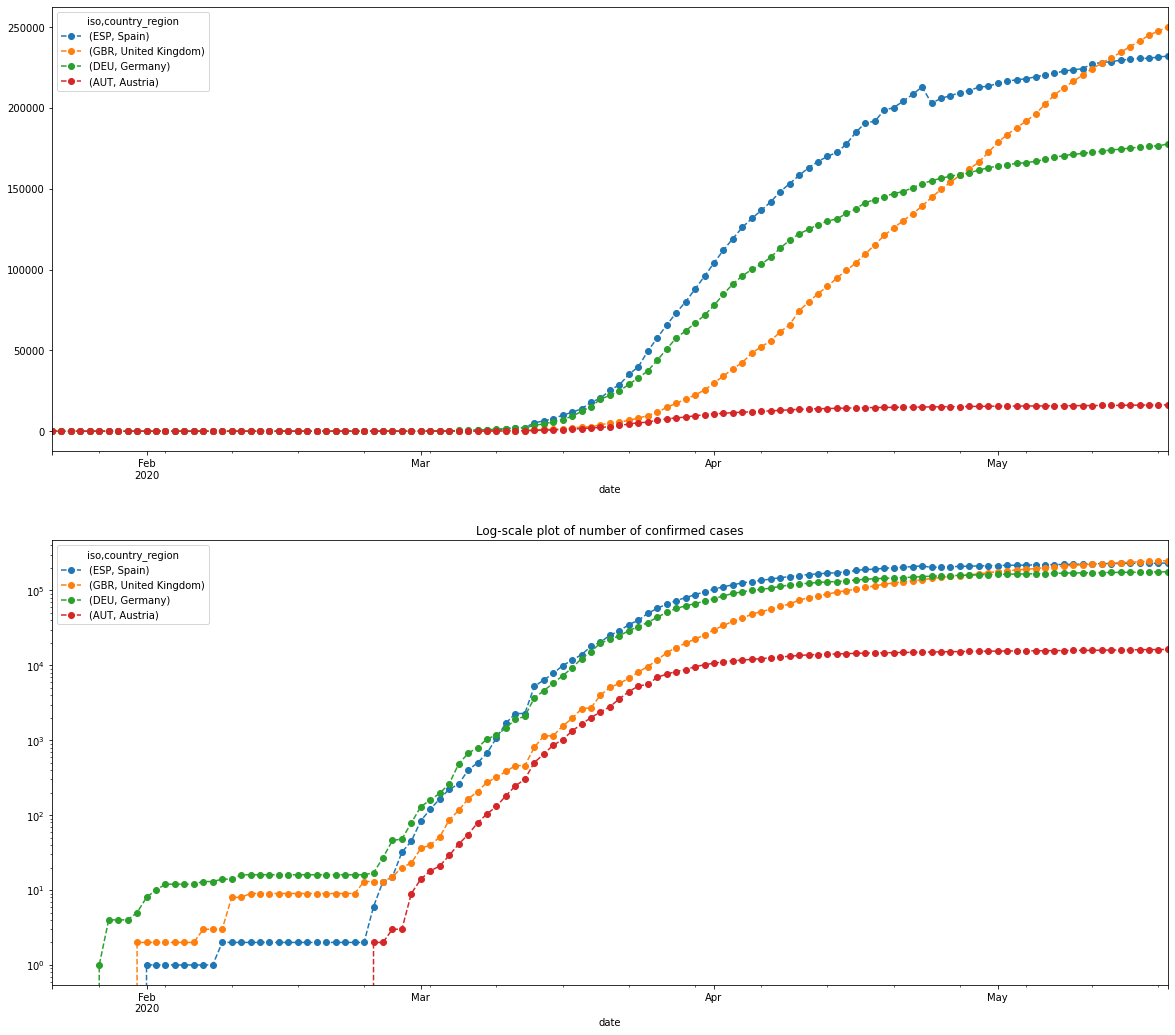

In [6]:
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20, 18))
confirmed.plot(ax=top_ax, linestyle="--", marker="o")
confirmed.plot(ax=bottom_ax, linestyle="--", marker="o")
bottom_ax.set_yscale("log")
bottom_ax.set_title("Log-scale plot of number of confirmed cases")

Text(0.5, 1.0, 'Log-scale plot of number of total deaths (daily confirmed)')

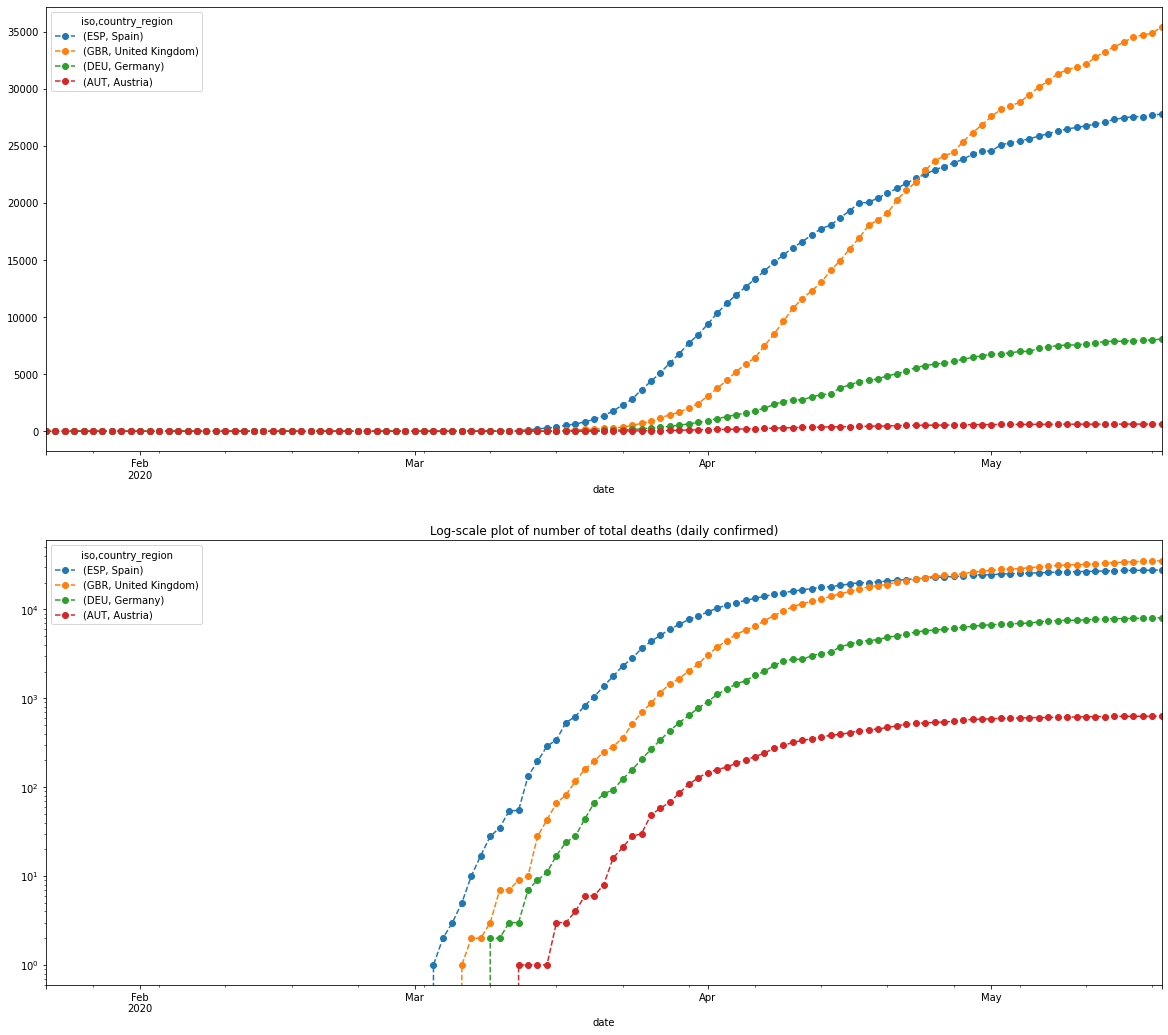

In [7]:
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20, 18))
dead.plot(ax=top_ax, linestyle="--", marker="o")
dead.plot(ax=bottom_ax, linestyle="--", marker="o")
bottom_ax.set_yscale("log")
bottom_ax.set_title("Log-scale plot of number of total deaths (daily confirmed)")

## Detailed analysis for UK and Spain and predictions

In [8]:
# Base Data
confirmed = confirmed[["ESP", "GBR"]]
dead = dead[["ESP", "GBR"]]
last_day = confirmed.iloc[-1]
countries_of_interest = confirmed.columns[last_day.argsort()][::-1]
growth_rate = confirmed.pct_change()
abs_growth_confirmed = confirmed.diff()
abs_growth_deaths = dead.diff()

In [9]:
# Derived Data for plots
date_lockdown_ES = "2020-03-14"
date_lockdown_UK = "2020-03-23"
idx_lockdown_ES = confirmed.index.get_loc(date_lockdown_ES)
idx_lockdown_UK = confirmed.index.get_loc(date_lockdown_UK)

confirmed_on_lockdown_ES = abs_growth_confirmed["ESP"].iloc[idx_lockdown_ES]
confirmed_on_lockdown_UK = abs_growth_confirmed["GBR"].iloc[idx_lockdown_UK]

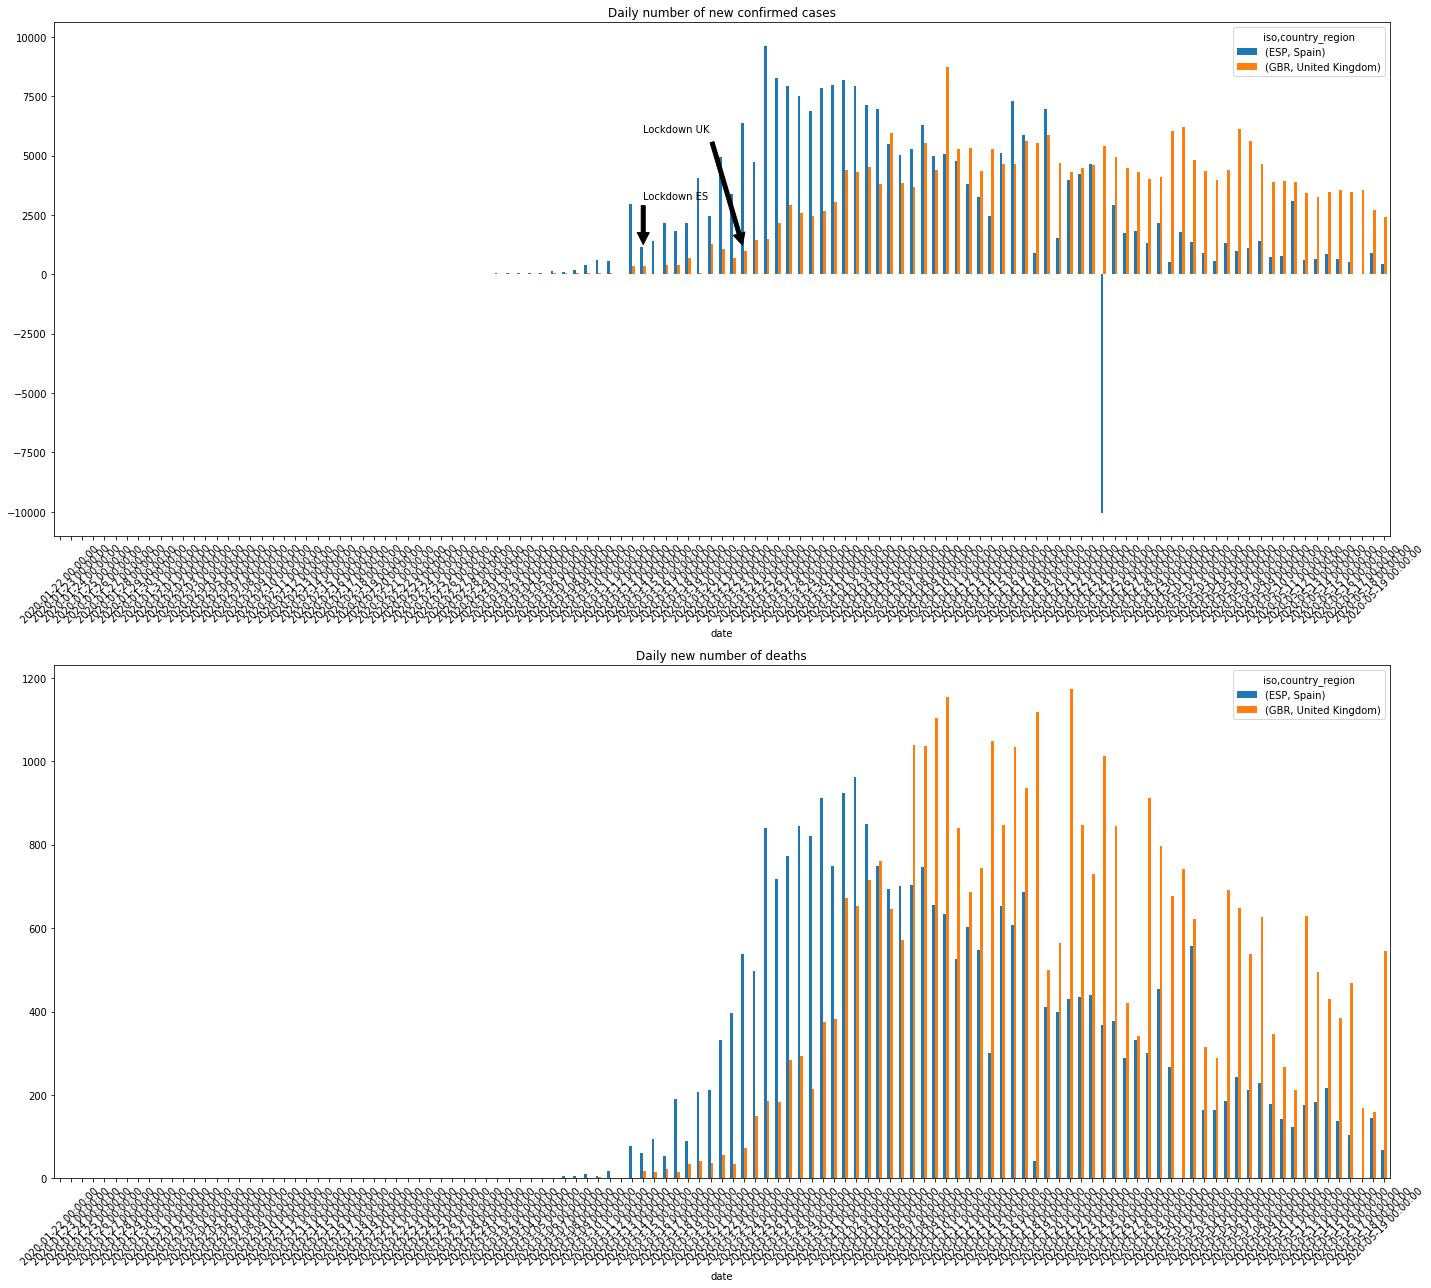

In [10]:
# Plot
fig, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(20, 18))
abs_growth_confirmed.plot.bar(ax=top_ax, rot=45)
abs_growth_deaths.plot.bar(ax=bottom_ax, rot=45)
# plt.setp(top_ax.get_xticklabels()[::2], visible=False)
# plt.setp(bottom_ax.get_xticklabels()[::2], visible=False)
top_ax.set_title("Daily number of new confirmed cases")
top_ax.annotate(
    "Lockdown ES",
    xy=(idx_lockdown_ES, confirmed_on_lockdown_ES),
    xytext=(idx_lockdown_ES, confirmed_on_lockdown_ES + 2000),
    arrowprops=dict(facecolor="black", shrink=0.05),
)
top_ax.annotate(
    "Lockdown UK",
    xy=(idx_lockdown_UK, confirmed_on_lockdown_UK),
    xytext=(idx_lockdown_ES, confirmed_on_lockdown_UK + 5000),
    arrowprops=dict(facecolor="black", shrink=0.05),
)
bottom_ax.set_title("Daily new number of deaths")
plt.tight_layout()

### Predictive model: a simple approach

In [11]:
import numpy as np

NUM_DAYS = 17  # How many days ago, length of the window
# Build exponential weighting function


def exp_window(length=14, growth=1.1):
    window = growth ** np.arange(length)
    window = window / window.sum()
    return window

Text(0.5, 1.0, 'Weights over last 17 days.')

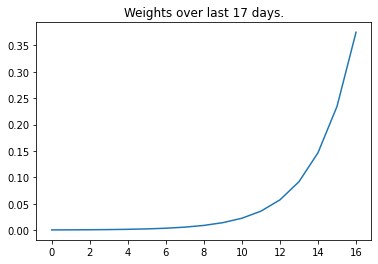

In [12]:
weighted_window = exp_window(length=NUM_DAYS, growth=1.6)
plt.figure()
plt.plot(weighted_window)
plt.title(f"Weights over last {NUM_DAYS} days.")

In [13]:
import pandas as pd

import statsmodels.api as sm

def fit_on_window(data, window):
    """ Fit the last window of the data
    """
    window_size = len(window)
    analysis_interval = data.iloc[-window_size:]
    log_analysis_interval = np.log(analysis_interval)
    log_analysis_interval[log_analysis_interval == -np.inf] = 0

    design = pd.DataFrame({'linear': np.arange(window_size),
                           'const': np.ones(window_size)})

    growth_rate = pd.DataFrame(data=np.zeros((1, len(data.columns))),
                               columns=data.columns)

    predicted_data = pd.DataFrame()
    predicted_data_lower = pd.DataFrame()
    predicted_data_upper = pd.DataFrame()
    prediction_dates = pd.date_range(data.index[-window_size],
                                    periods=window_size + 7)

    for country in data.columns:
        mod_wls = sm.WLS(log_analysis_interval[country].values, design,
                         weights=window, hasconst=True)
        res_wls = mod_wls.fit()
        growth_rate[country] = np.exp(res_wls.params.linear)
        predicted_data[country] = np.exp(res_wls.params.const +
                res_wls.params.linear * np.arange(len(prediction_dates))
            )
        # 1st and 3rd quartiles in the confidence intervals
        conf_int = res_wls.conf_int(alpha=.25)
        # We chose to account only for error in growth rate, and not in
        # baseline number of cases
        predicted_data_lower[country] = np.exp(res_wls.params.const +
                conf_int[0].linear * np.arange(len(prediction_dates))
            )
        predicted_data_upper[country] = np.exp(res_wls.params.const +
                conf_int[1].linear * np.arange(len(prediction_dates))
            )

    predicted_data = pd.concat(dict(prediction=predicted_data,
                                     lower_bound=predicted_data_lower,
                                     upper_bound=predicted_data_upper),
                                axis=1)
    predicted_data['date'] = prediction_dates
    predicted_data = predicted_data.set_index('date')
    if window_size > 10:
        # Don't show predictions more than 10 days ago
        predicted_data  = predicted_data.iloc[window_size - 10:]

    return growth_rate, predicted_data

#### Predicted Cases

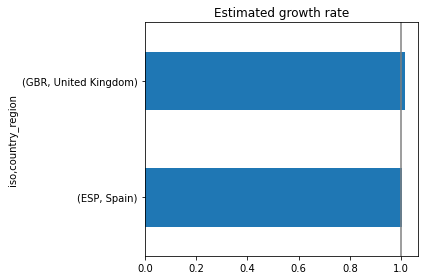

In [14]:
growth_rate, predicted_cases = fit_on_window(confirmed, weighted_window)

ax = growth_rate.T.plot(kind="barh", legend=False)
ax.set_title("Estimated growth rate")
ax.axvline(1, color=".5")
plt.tight_layout()

In [15]:
growth_rate

iso,ESP,GBR
country_region,Spain,United Kingdom
0,1.002778,1.013783


Text(0.5, 1.0, 'Number of confirmed cases in the last fortnight and prediction')

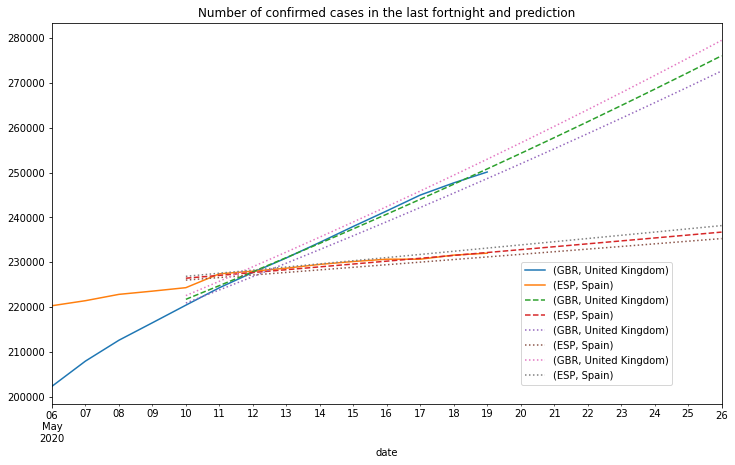

In [16]:
last_fortnight = confirmed.iloc[-14:]

ax = last_fortnight[countries_of_interest].plot(figsize=(12, 7))
predicted_cases["prediction"][countries_of_interest].plot(ax=ax, style="--")
predicted_cases["lower_bound"][countries_of_interest].plot(ax=ax, style=":")
predicted_cases["upper_bound"][countries_of_interest].plot(ax=ax, style=":")

plt.legend(loc=(0.7, 0.05))
ax.set_title("Number of confirmed cases in the last fortnight and prediction")

In [17]:
predicted_cases

prediction                          lower_bound  \
             (ESP, Spain) (GBR, United Kingdom)   (ESP, Spain)   
date                                                             
2020-05-10  226459.983064         221749.938039  226039.463163   
2020-05-11  227089.108070         224806.412295  226607.242723   
2020-05-12  227719.980839         227905.015243  227176.448466   
2020-05-13  228352.606227         231046.327562  227747.083974   
2020-05-14  228986.989101         234230.937932  228319.152839   
2020-05-15  229623.134344         237459.443148  228892.658661   
2020-05-16  230261.046853         240732.448234  229467.605049   
2020-05-17  230900.731537         244050.566549  230043.995623   
2020-05-18  231542.193319         247414.419907  230621.834009   
2020-05-19  232185.437136         250824.638696  231201.123844   
2020-05-20  232830.467938         254281.861989  231781.868775   
2020-05-21  233477.290691         257786.737670  232364.072455   
2020-05-22  234125.910373         261339.922551  232947.738550   
2020-05-23  234776.331975         264942.082500  233532.870733   
2020-05-24  235428.560503         268593.892560  234119.472686   
2020-05-25  236082.600977         272296.037080  234707.548101   
2020-05-26  236738.458431         276049.209842  235297.100680   

                                    upper_bound                        
           (GBR, United Kingdom)   (ESP, Spain) (GBR, United Kingdom)  
date                                                                   
2020-05-10         220916.729552  226881.285292         222586.289050  
2020-05-11         223841.308287  227571.998072         225775.677401  
2020-05-12         226804.603695  228264.813645         229010.765773  
2020-05-13         229807.128322  228959.738411         232292.208991  
2020-05-14         232849.401499  229656.778792         235620.671263  
2020-05-15         235931.949432  230355.941228         238996.826314  
2020-05-16         239055.305294  231057.232181         242421.357524  
2020-05-17         242220.009315  231760.658129         245894.958064  
2020-05-18         245426.608878  232466.225573         249418.331036  
2020-05-19         248675.658612  233173.941032         252992.189618  
2020-05-20         251967.720488  233883.811046         256617.257209  
2020-05-21         255303.363916  234595.842174         260294.267568  
2020-05-22         258683.165847  235310.040995         264023.964974  
2020-05-23         262107.710867  236026.414108         267807.104366  
2020-05-24         265577.591301  236744.968133         271644.451503  
2020-05-25         269093.407317  237465.709709         275536.783114  
2020-05-26         272655.767028  238188.645496         279484.887061

### Fatalities

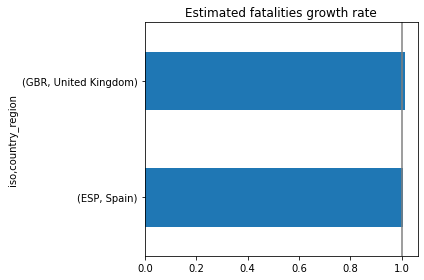

In [18]:
growth_rate, predicted_fatalities = fit_on_window(dead, weighted_window)

ax = growth_rate.T.plot(kind="barh", legend=False)
ax.set_title("Estimated fatalities growth rate")
ax.axvline(1, color=".5")
plt.tight_layout()

Text(0.5, 1.0, 'Number of confirmed fatalities in the last fortnight and prediction')

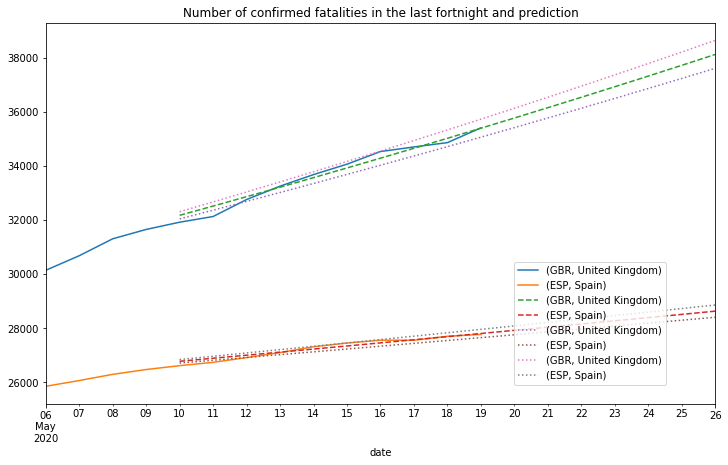

In [19]:
last_fortnight = dead.iloc[-14:]

ax = last_fortnight[countries_of_interest].plot(figsize=(12, 7))
predicted_fatalities["prediction"][countries_of_interest].plot(ax=ax, style="--")
predicted_fatalities["lower_bound"][countries_of_interest].plot(ax=ax, style=":")
predicted_fatalities["upper_bound"][countries_of_interest].plot(ax=ax, style=":")

plt.legend(loc=(0.7, 0.05))
ax.set_title("Number of confirmed fatalities in the last fortnight and prediction")